In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import optimize

In [2]:
k_min = 0.01
k_max = 10
N = 50
beta = 0.99
tolerance = 1e-5
iterations = 1000
k_grid = np.linspace(k_min, k_max, N)
p_grid = np.ones((2, N)) * k_min
k_grid_2D = np.zeros_like(p_grid)
k_grid_2D[0,:] = k_grid
k_grid_2D[1,:] = k_grid

In [3]:
# Utility function
def u(c):
    return np.log(c)

# Derivative of utility function
def du_dc(c):
    return 1./c

# Getting f 
def f(k, method=None):
    f = np.zeros((2, N))
    f[0,:] = 0.9*k[0,:]**0.3 + 0.3 * k[0,:]
    f[1,:] = 1.1*k[1,:]**0.3 + 0.9* k[1,:]
    
    if method == 'mean':
        return f.mean(axis=0)

    else:
        return f

# Getting the derivative of f
def df_dx(k, method = None):
    
    df = np.zeros((2, N))
    df[0,:] = 0.9*0.3*k[0,:]**(0.3-1) +0.3
    df[1,:] = 1.1*0.3*k[1,:]**(0.3-1) +0.9
    
    if method == 'mean':
        return df.mean(axis=0)
    else:
        return df

def R(p_grid, p_grid_old):
    # reshaping p_grid
    p_grid = p_grid.reshape(2, N)
    
    
    # Create the two seperate interpolations
    PL1 = interp1d(k_grid, p_grid_old[0,:], kind= 'linear',fill_value='extrapolate')
    PL2 = interp1d(k_grid, p_grid_old[1,:], kind = 'linear', fill_value='extrapolate')
    
    # Get PL as a (2, N) interpolation
    PL_state1 = np.zeros((2, N))
    PL_state2 = np.zeros((2, N))
    
    PL_state1[0,:] = PL1(p_grid[0,:])
    PL_state1[1, :] = PL2(p_grid[0,:])
    
    PL_state2[0,:] = PL1(p_grid[1,:])
    PL_state2[1,:] = PL2(p_grid[1,:])
    
    # Calculate the first part of the equation
    part1 = du_dc(f(k_grid_2D)-p_grid)
    
    # Calculate the second part of the equation
    curr_temp1 = np.concatenate((p_grid[0, :].reshape(1,N), p_grid[0, :].reshape(1,N)))
    curr_temp2 = np.concatenate((p_grid[0, :].reshape(1,N), p_grid[0, :].reshape(1,N)))
    part2_state1 = df_dx(curr_temp1) * du_dc(f(curr_temp2) - PL_state1)
    part2_state1 = (beta* part2_state1.mean(axis=0)).reshape(1,N)
    
    curr_temp1 = np.concatenate((p_grid[1, :].reshape(1,N), p_grid[1, :].reshape(1,N)))
    curr_temp2 = np.concatenate((p_grid[1, :].reshape(1,N), p_grid[1, :].reshape(1,N)))
    part2_state2 = df_dx(curr_temp1) * du_dc(f(curr_temp2) - PL_state2)
    part2_state2 = (beta* part2_state2.mean(axis=0)).reshape(1,N)
    
    
    
    output = part1 - np.concatenate((part2_state1, part2_state2))
    # Outputting in vector form
    output_vector = output.ravel()
    return output_vector
    

def solve_R(p_grid):
    
    
    p_grid_old = p_grid.copy()
    
    def tempR(p): 
        return R(p, p_grid_old)
    
    
    p_grid_vector = p_grid.ravel()
    sol = optimize.fsolve(tempR, p_grid_vector)
    sol = sol.reshape(2, N)
    return sol

In [4]:
for i in range(iterations):
    sol = solve_R(p_grid)
    p_grid = sol.copy()
    if p_grid.max() < tolerance:
        print('Converged!')
        break

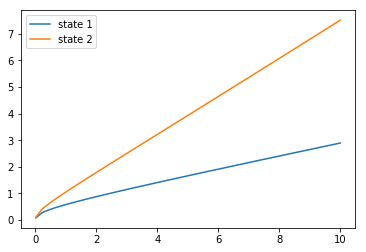

In [5]:
plt.plot(k_grid, sol[0,:], label = 'state 1')
plt.plot(k_grid, sol[1,:], label = 'state 2')

plt.legend()
plt.show()